# A Netflix Tour of Data Science - Film suggestion by diffusion on graphs
# Adjacency - Genres

### Students:

    * Team     : 17
    * Students : Edwige Avignon, Kenneth Nguyen, Pierre Fourcade  
    * Dataset  : Kaggle dataset - Films and Crew

## About this notebook:

This notebook is used to create and export an adjacency matrix built from the genres of the movies.
For that we use a dataset regrouping all the needed informations.

The goal here is to build a graph where the nodes represent the different movies of the dataset we are working with, and the edges are determined from the genres. The edges and their weights must represent how strong is the similarity between two movies, according to their genres.
To build a meaningful adjacency matrix from the genres we have taken into account the following points:

1. The genres in the dataset are mentioned in a specific order: starting with the most emblematic ones, to the more specific ones.
2. If no genres are mentionned in the dataset the movie is considered as isolated (we do not consider no genres as a genre in itself).
3. The weights are determined by the order and the number of common genres:
    - If the first genre of the movie considered does not match the first or the second genre of the other movie: the nodes are not connected
    - If the first genre of the movie considered match the second genre of the other movie and if the second genre of the movie considered match the first genre of the other movie: unit weight
    - If only the first genres of the two movies match: 2 x (unit weight)
    - If the first and the second genres match one another: 4 x (unit weight)
    - If the two genre lists contain more than two genres and are strictly identical : 8 x (unit weight)

The important point in the weights is not the value in itself, as we will normalize them afterwards, but the gap between the different levels that we have considered.
We can also note that the graph we want to create is undirected.

## 0 - Libraries, dataset and usefull functions

In [1]:
import numpy as np
import pandas as pd
import pygsp as pg
import networkx as nx
import matplotlib.pyplot as plt
import ast
from collections import Counter

In [2]:
credits = pd.read_csv('Dataset_Exports/tmdb_5000_credits.csv')
movies = pd.read_csv('Dataset_Exports/tmdb_5000_movies.csv')

In [3]:
def convert_list(list_dict):
    newdict={}
    for k,v in [(key,d[key]) for d in 
    ast.literal_eval(list_dict) for key in d]:
        if k not in newdict: newdict[k]=[v]
        else: newdict[k].append(v)
    return newdict

In [4]:
def convert_dict_to_features(x):
    try:
        return x[k]
    except:
        return []

In [5]:
def all_connected_nodes(adjacency):
    connected_nodes = []
    for i in range (len(adjacency)):
        sum = np.sum(adjacency[i])
        if sum != 0:
            connected_nodes.append(i)
    return np.array(connected_nodes)

In [6]:
def remove_isolated_nodes(connected_nodes,adjacency):
    adjacency_connected = np.zeros((len(connected_nodes),len(connected_nodes)))
    for i in range (len(connected_nodes)):
        for j in range (len(connected_nodes)):
              adjacency_connected[i,j] = adjacency[connected_nodes[i],[connected_nodes[j]]] 
    return adjacency_connected

## 1 - Adjacency - Genres

Let's build the adjacency.

For that we need, at first, to extract the genres from the dataset.

In [7]:
movies.rename(columns={'id':'movie_id'},inplace=True)

In [8]:
compact_dict = movies.genres.apply(lambda x: convert_list(x))
for (k, v) in compact_dict[0].items():
    movies[k] = compact_dict.apply(lambda x: convert_dict_to_features(x))

In [9]:
movies.rename(columns={'id':'genres_id', 'name':'genres_name'},inplace=True)
movies_restricted = movies[['movie_id', 'title', 'genres_name', 'genres_id',]].copy()

In [12]:
movies_restricted.head()

,movie_id,title,genres_name,genres_id
0,19995,Avatar,"[Action, Adventure, Fantasy, Science Fiction]","[28, 12, 14, 878]"
1,285,Pirates of the Caribbean: At World's End,"[Adventure, Fantasy, Action]","[12, 14, 28]"
2,206647,Spectre,"[Action, Adventure, Crime]","[28, 12, 80]"
3,49026,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[28, 80, 18, 53]"
4,49529,John Carter,"[Action, Adventure, Science Fiction]","[28, 12, 878]"


Now that we have the id of the different genres we can build the top-half of the adjacency. Indeed, as it is symmetrical in regards of the diagonal, it is faster to just mirror the top-half after.

In [11]:
adjacency_weighted = np.zeros((len(movies_restricted),len(movies_restricted)))
adjacency = np.zeros((len(movies_restricted),len(movies_restricted)))
np.shape(adjacency)

(4803, 4803)

In [12]:
# We build the top-half of the adjacency:

for i in range (len(movies_restricted)): 
    node = np.array(movies_restricted.genres_id[i])
    for j in range (i+1,len(movies_restricted)): 
        other_node = np.array(movies_restricted.genres_id[j])
        if len(node) == 0 or len(other_node) == 0:
            adjacency_weighted[i,j] = 0
        elif len(node) == 1 or len(other_node) == 1:
            if node[0] == other_node[0]:
                adjacency_weighted[i,j] = 2
            else:
                adjacency_weighted[i,j] = 0
        elif len(node) == 2 or len(other_node) == 2:
            if node[0] == other_node[0]:
                if node[1] == other_node[1]:
                    adjacency_weighted[i,j] = 4
                else:
                    adjacency_weighted[i,j] = 2
            elif node[1] == other_node[0] and node[0] == other_node[1]:
                adjacency_weighted[i,j] = 1
            else:
                adjacency_weighted[i,j] = 0
        else:
            if len(node) == len(other_node):
                if node[0] == other_node[0]:
                    if node[1] == other_node[1]:
                        for k in range (2,len(node)):
                            if node[k] != other_node[k]:
                                equal = False
                                break
                            else:
                                equal = True
                        if equal == True:
                            adjacency_weighted[i,j] = 8
                        else:
                            adjacency_weighted[i,j] = 4
                    else:
                        adjacency_weighted[i,j] = 2
                elif node[1] == other_node[0] and node[0] == other_node[1]:
                    adjacency_weighted[i,j] = 1
                else:
                    adjacency_weighted[i,j] = 0
            else:
                if node[0] == other_node[0]:
                    if node[1] == other_node[1]:
                        adjacency_weighted[i,j] = 4
                    else:
                        adjacency_weighted[i,j] = 2
                elif node[1] == other_node[0] and node[0] == other_node[1]:
                    adjacency_weighted[i,j] = 1
                else:
                    adjacency_weighted[i,j] = 0      

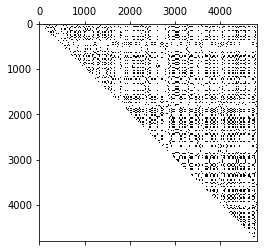

In [13]:
plt.spy(adjacency_weighted)

As we can see from this top-half of the adjacency, the graph is very connected. We will use the fully connected graph for the different applications of this project so that we don't loose any information. However, for the sake of the representation on Gephi we have to reduce the number of edges.
The idea to reduce the number of edges is to reduce the number of parallel edges. Indeed, for instance each [Action,Adventure] movies are connected to all the [Adventure,Action]. We will try to reduce this kind of edges, only for the sake of representation.

To reduce the number of parallel edges we will use the following procedure:

1. For a node we count the number of edges for the different type of weights.
2. For each node and for each type of weights we save 5 edges (randomly) and set to 0 the others.

In [14]:
adjacency_weighted_reduced = np.copy(adjacency_weighted)
adjacency_reduced = np.zeros((len(adjacency_weighted),len(adjacency_weighted)))
np.shape(adjacency_reduced)

(4803, 4803)

In [15]:
# We reduce the number of parallel edges:

for i in range (len(adjacency_weighted_reduced)):
    weight_1 = []
    weight_2 = []
    weight_4 = []
    for j in range (i+1,len(adjacency_weighted_reduced)):
        if adjacency_weighted[i,j] == 1:
            weight_1.append(j)
        elif adjacency_weighted[i,j] == 2:
            weight_2.append(j)
        elif adjacency_weighted[i,j] == 4:
            weight_4.append(j)
    if len(weight_1) > 5:
        for k in range (len(weight_1)-5):
            adjacency_weighted_reduced[i,np.random.choice(weight_1)] = 0
    if len(weight_2) > 5:
        for k in range (len(weight_2)-5):
            adjacency_weighted_reduced[i,np.random.choice(weight_2)] = 0
    if len(weight_4) > 5:
        for k in range (len(weight_4)-5):
            adjacency_weighted_reduced[i,np.random.choice(weight_4)] = 0     

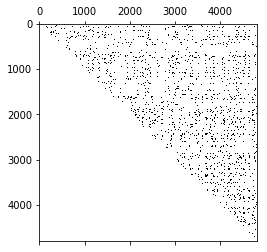

In [16]:
plt.spy(adjacency_weighted_reduced)

Now, let's complete the adjacency matrices.

In [17]:
# We complete the low-half of the adjacency:

for i in range (len(adjacency_weighted)):
    for j in range (i+1,len(adjacency_weighted)):
        adjacency_weighted[j,i] = adjacency_weighted[i,j]
        
for i in range (len(adjacency_weighted_reduced)):
    for j in range (i+1,len(adjacency_weighted_reduced)):
        adjacency_weighted_reduced[j,i] = adjacency_weighted_reduced[i,j]

In [18]:
# We also build an unweighted adjacency:

for i in range (len(adjacency)):
    for j in range (len(adjacency)):
        if adjacency_weighted[i,j] != 0:
            adjacency[i,j] = 1
            
for i in range (len(adjacency_reduced)):
    for j in range (len(adjacency_reduced)):
        if adjacency_weighted_reduced[i,j] != 0:
            adjacency_reduced[i,j] = 1

In [19]:
# We save the adjacency matrices:

np.savetxt('Dataset_Exports/Genres/Adjacency_Genres_Weighted.txt', adjacency_weighted)
np.savetxt('Dataset_Exports/Genres/Adjacency_Genres.txt', adjacency)
np.savetxt('Dataset_Exports/Genres/Adjacency_Genres_Weighted_Reduced.txt', adjacency_weighted_reduced)
np.savetxt('Dataset_Exports/Genres/Adjacency_Genres_Reduced.txt', adjacency_reduced)

We normalize the weights of the adjacency matrices.

In [20]:
adjacency_weighted_normalized = np.zeros((len(adjacency_weighted),len(adjacency_weighted)))
adjacency_weighted_reduced_normalized = np.zeros((len(adjacency_weighted_reduced),len(adjacency_weighted_reduced)))

In [21]:
# We normalize the two adjency matrices:

max_weight = np.max(adjacency_weighted)

for i in range (len(adjacency_weighted_normalized)):
    for j in range (len(adjacency_weighted_normalized)):
        if adjacency_weighted[i,j] == 0:
            adjacency_weighted_normalized[i,j] = 0
        else:
            adjacency_weighted_normalized[i,j] = adjacency_weighted[i,j]/max_weight

for i in range (len(adjacency_weighted_reduced_normalized)):
    for j in range (len(adjacency_weighted_reduced_normalized)):
        if adjacency_weighted_reduced[i,j] == 0:
            adjacency_weighted_reduced_normalized[i,j] = 0
        else:
            adjacency_weighted_reduced_normalized[i,j] = adjacency_weighted_reduced[i,j]/max_weight

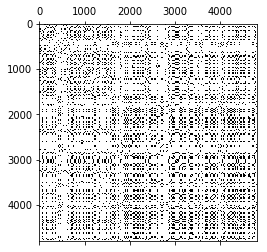

In [22]:
plt.spy(adjacency_weighted_normalized)

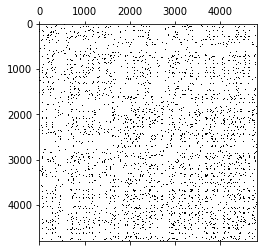

In [23]:
plt.spy(adjacency_weighted_reduced_normalized)

In [24]:
# We save the normalized adjacency matrices:

np.savetxt('Dataset_Exports/Genres/Adjacency_Genres_Weighted_Normalized.txt', adjacency_weighted_normalized)
np.savetxt('Dataset_Exports/Genres/Adjacency_Genres_Weighted_Reduced_Normalized.txt', adjacency_weighted_reduced_normalized)

## 2 - Exporting the graph for Gephi (by using Networkx)

Now we will create the graph of the reduced adjacency we have built. We can quickly represent it here with Networkx but the core of our observations will be made with Gephi.

In [25]:
adjacency_weighted_normalized = np.loadtxt('Dataset_Exports/Genres/Adjacency_Genres_Weighted_Normalized.txt')
adjacency_weighted_reduced_normalized = np.loadtxt('Dataset_Exports/Genres/Adjacency_Genres_Weighted_Reduced_Normalized.txt')

In [26]:
Graph = nx.from_numpy_array(adjacency_weighted_reduced_normalized)

D:\Programmes_DD\Applications\Anaconda3\envs\ntds_2018\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


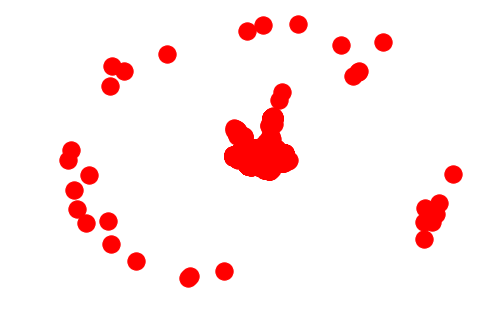

In [27]:
nx.draw_spring(Graph)

In [28]:
nx.write_gexf(Graph,'Dataset_Exports/Genres/Graph_Genres.gexf')